# Objective:

Classify Amazon food reviews using SGDClassifier with hinge loss (Linear SVM).

We'll do the following exercises in this notebook

* Load and standardize the data in the format
        1. BoW
        2. Tfidf
        3. Avg. W2V
        4. Tfidf weighted W2V
* Divide the data in cross validation sets and find the optimal parameters **penalty** and **alpha** using GridSearchCV and RandomizedSearchCV
* Plot the Cross Validation score for each combination of penalty and alpha
* Plot confusion matrix and calculate Precision, Recall, FPR, TNR, FNR. 



In [1]:
# To suprress the warnings as they make the notebook less presentable.

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Import the necessary libraries.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np
from sklearn.linear_model import SGDClassifier

This Jupyter notebook extension notifies you when a cell finishes its execution!

In [3]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Important parameters of SGDClassifier

* penalty : Regularization term. L1 or L2
* alpha : Constant that multiplies the regularization term, also used to calculate the learning rate when it is set to 'optimal'

Load the target variable y of train and test sets. Note that the entire dataset is being used. All 350k reviews. The dataset is divided into train and test with ratio 80:20 respectively.

In [33]:
# f = open(r'D:\data_science\datasets\amazon2\y_train_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_train_full80_20.pkl', 'rb')
y_train = pickle.load(f)
f.close()
print('The datatype of y_train is : {}'.format(type(y_train)))
print('The shape of y_train is : {}'.format(y_train.shape))

The datatype of y_train is : <class 'numpy.ndarray'>
The shape of y_train is : (291336,)


In [34]:
# f = open(r'D:\data_science\datasets\amazon2\y_test_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_test_full80_20.pkl', 'rb')
y_test = pickle.load(f)
f.close()
print('The datatype of y_test is : {}'.format(type(y_test)))
print('The shape of y_test is : {}'.format(y_test.shape))

The datatype of y_test is : <class 'numpy.ndarray'>
The shape of y_test is : (72835,)


## Bag of Words

I had saved the trained BoW model and the transformed data on disk. Let's load it. 

In [35]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_bow_full_nparray.pkl', 'rb')
X_train_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_bow is : {}'.format(type(X_train_transformed_bow)))
print('The shape of X_train_transformed_bow is : {}'.format(X_train_transformed_bow.shape))

The datatype of X_train_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_bow is : (291336, 64221)


There are 64221 features in the bow representation. Load test data too.

In [36]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_bow_full_nparray.pkl', 'rb')
X_test_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_bow is : {}'.format(type(X_test_transformed_bow)))
print('The shape of X_test_transformed_bow is : {}'.format(X_test_transformed_bow.shape))

The datatype of X_test_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_bow is : (72835, 64221)


Count the number of non-zero elements in the array.

In [37]:
X_train_transformed_bow.count_nonzero

<bound method _data_matrix.count_nonzero of <291336x64221 sparse matrix of type '<class 'numpy.int64'>'
	with 9180635 stored elements in Compressed Sparse Row format>>

## Feature scaling

Standardize the data.

In [ ]:
scaler = StandardScaler(with_mean = False)
X_train_transformed_bow_std = scaler.fit_transform(X_train_transformed_bow)

In [ ]:
X_test_transformed_bow_std = scaler.transform(X_test_transformed_bow)

In [40]:
X_train_transformed_bow_std.shape

(291336, 64221)

In [41]:
y_train.shape

(291336,)

## Some Functions

Let's define some functions that we'll call repeatedly in this notebook. 

1. **penalty_alpha_score** : Returns a dataframe containing the penalty, alpha, score found during cross validation

2. **give_me_ratios** : To plot ratios such as Precision, Recall, TNR, FPR, FNR.
3. **plot_confusion_matrix** : As the name says.
4. **GridSearch** : Create Time based cross validation splits using TimeSeriesSplit() and  create a gridsearch object for a support vector classifier.
5. **RandomSearch**: Same as GridSearch except that it uses RandomizedSearchCV()
6. **headmap** : For each pair of (penalty, alpha) value in GridSearch, it will plot the score for train and test data during cross validation. For RandomizedSearchCV, for the pair of values not tried by the classifier, it will show -1 (NA).

In [42]:
def penalty_alpha_score(cv_results_):

    D={'penalty':[], 'alpha':[], 'score':[]}

    for penalty in ['l1', 'l2']:

        for alpha in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:

            d={'penalty': penalty, 'alpha': alpha}
            
            flag=True
            
            try:
            
                ind=cv_results_['params'].index(d)
            
            except:
                
                flag = False

            D['penalty'].append(penalty)
            D['alpha'].append(alpha)
            
            if flag == False:
                
                D['score'].append(-1)
            
            else:
                D['score'].append(cv_results_['mean_train_score'][ind])
                
    return(pd.DataFrame.from_dict(D)) 

In [53]:
def give_me_ratios(X_train, y_train, X_test, y_test, vector_type,search, table, clf, best_penalty, best_alpha): 
    
    cm_train = confusion_matrix(y_train, clf.predict(X_train))
    tn, fp, fn, tp = cm_train.ravel()

    recall_train = round(tp/(tp+fn),2)
    precision_train = round(tp/(tp+fp),2)
    tnr_train = round(tn/(tn+fp),2)
    fpr_train = round(fp/(fp+tn),2)
    fnr_train = round(fn/(fn+tp),2)
    #accuracy_train = round((tp+tn)/(tp+tn+fp+fn))
    accuracy_train = round((tp+tn)/(tp+tn+fp+fn), 4)

    cm_test = confusion_matrix(y_test, clf.predict(X_test))
    tn, fp, fn, tp = cm_test.ravel()
    recall_test = round(tp/(tp+fn),2)
    precision_test = round(tp/(tp+fp),2)
    tnr_test = round(tn/(tn+fp),2)
    fpr_test = round(fp/(fp+tn),2)
    fnr_test = round(fn/(fn+tp),2)
    accuracy_test = round((tp+tn)/(tp+tn+fp+fn), 4)

    table.field_names = ['Vector Type','Parameter Srch','Data','Best penalty','Best alpha', 'Prec', 'Rec', 'TNR', 'FPR', 'FNR', 'Acc']
    table.add_row([vector_type,search,'Train',best_penalty,best_alpha, precision_train, recall_train, tnr_train, fpr_train, fnr_train, accuracy_train])
    table.add_row([vector_type,search,'Test',best_penalty,best_alpha, precision_test, recall_test, tnr_test, fpr_test, fnr_test, accuracy_test])

    print(table)
    
    return (cm_train, cm_test)

In [44]:
def plot_confusion_matrix(cm_train, cm_test, title):
    
    import pandas as pd
    plt.figure(figsize=(15,6)).suptitle(title, fontsize=15)
    
    plt.subplot(1,2,1)
    df_cm = pd.DataFrame(cm_train, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="YlGnBu")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    plt.ylabel('Actual Class', fontsize=15)
    plt.title('Train Data', fontsize = 14)

    plt.subplot(1,2,2)    
    df_cm = pd.DataFrame(cm_test, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="YlGnBu")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    # plt.ylabel('Actual Class', fontsize=15)

    plt.title('Test Data', fontsize = 14)

    plt.tight_layout()

In [45]:
def GridSearch(X_train):

    tscv = TimeSeriesSplit(n_splits=4)
    my_cv = tscv.split(X_train)

    svm_linear = SGDClassifier(loss='hinge')
    
    hyp_par = {
                'penalty':[ 'l1', 'l2'],
                'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        
        }

    clf = GridSearchCV(estimator=svm_linear, cv=my_cv, param_grid=hyp_par, n_jobs=12, return_train_score=True)
        
    return clf

In [46]:
def RandomSearch(X_train):

    tscv = TimeSeriesSplit(n_splits=4)
    my_cv = tscv.split(X_train)

    svm_linear = SGDClassifier(loss='hinge')
    
    hyp_par = {
                'penalty':[ 'l1', 'l2'],
                'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        
        }
    
    clf = RandomizedSearchCV(estimator=svm_linear, cv=my_cv, param_distributions=hyp_par, n_jobs=12, return_train_score=True)
    
    return clf

In [47]:
def heatmap(df, vector_type, search_type):

    plt.figure(figsize=(15,6))

    plt.subplot(1,1,1)
    sbn.heatmap(data=df.pivot('penalty','alpha','score'), annot=True, linewidth = 0.5, cmap="YlGnBu")
    plt.title('{} | Training/CV set | {}'.format(vector_type, search_type), fontsize = 15)
    plt.xlabel('alpha', fontsize = 14)
    plt.ylabel('penalty', fontsize = 14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.tight_layout()
    plt.show()

**BoW | GridSearchCV**

Get the classifier by calling the GridSearch funtion.

In [48]:
clf_grid = GridSearch(X_train_transformed_bow_std)

Train the model

In [49]:
%%notify
%%time

clf_grid.fit(X_train_transformed_bow_std, y_train)

CPU times: user 1.9 s, sys: 84.9 ms, total: 1.98 s
Wall time: 9.14 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fed3821ad58>,
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=12,
       param_grid={'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Heatmap | BoW | Grid Search**

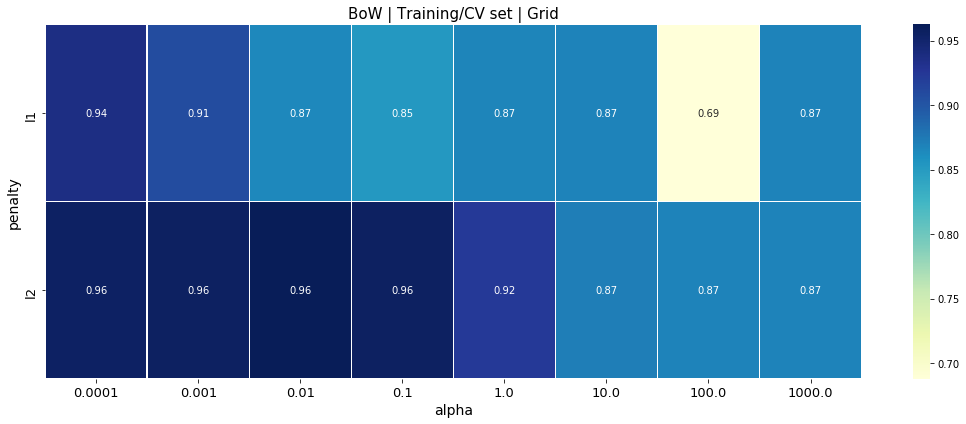

In [50]:
heatmap(penalty_alpha_score(clf_grid.cv_results_), vector_type='BoW', search_type='Grid')

Import prettytable to summarize the results in a table

In [54]:
from prettytable import PrettyTable
table = PrettyTable()

**Ratios | BoW | Grid Search**

In [55]:
cm_bow_train, cm_bow_test = give_me_ratios(X_train_transformed_bow_std, y_train, X_test_transformed_bow_std, y_test, 'Bag of Words','Grid Search', table, clf_grid, clf_grid.best_params_['penalty'],clf_grid.best_params_['alpha'])

+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Vector Type  | Parameter Srch |  Data | Best penalty | Best alpha | Prec | Rec  | TNR  | FPR  | FNR  |  Acc   |
+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Bag of Words |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9461 |
| Bag of Words |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.61 | 0.39 | 0.03 | 0.9085 |
+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+


**Confusion Matrix | BoW | Grid Search**

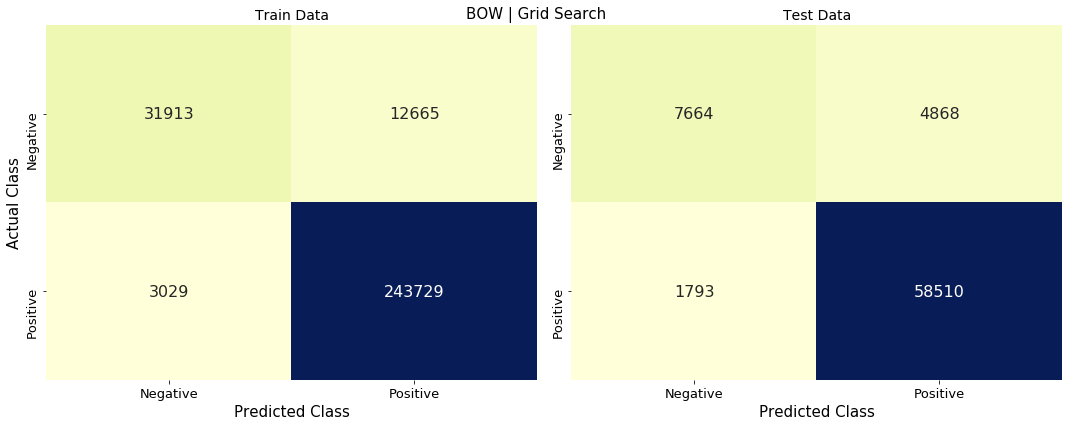

In [56]:
plot_confusion_matrix(cm_bow_train, cm_bow_test, title="BOW | Grid Search")

**Random Search | BOW**

Same as before, but this time using RandomizedSearchCV()

In [57]:
clf_random = RandomSearch(X_train_transformed_bow_std)

In [58]:
%%notify
%%time

clf_random.fit(X_train_transformed_bow_std, y_train)

CPU times: user 1.84 s, sys: 98.4 ms, total: 1.93 s
Wall time: 5.23 s


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fed38145fc0>,
          error_score='raise-deprecating',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=12,
          param_distributions={'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Heatmap | BoW | Random Search**

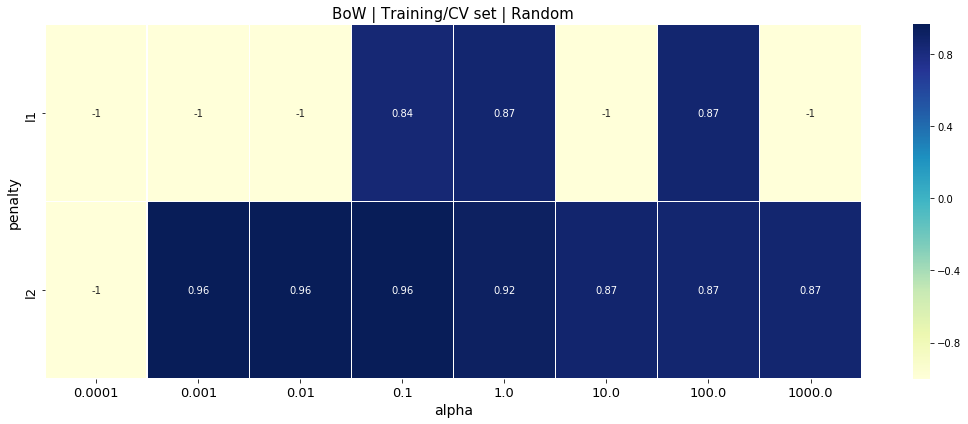

In [59]:
heatmap(penalty_alpha_score(clf_random.cv_results_), vector_type='BoW', search_type='Random')

**Ratios | BoW | Random Search**

In [60]:
cm_bow_train, cm_bow_test = give_me_ratios(X_train_transformed_bow_std, y_train, X_test_transformed_bow_std, y_test, 'Bag of Words','Random Search', table, clf_random, clf_random.best_params_['penalty'],clf_random.best_params_['alpha'])

+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Vector Type  | Parameter Srch |  Data | Best penalty | Best alpha | Prec | Rec  | TNR  | FPR  | FNR  |  Acc   |
+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Bag of Words |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9461 |
| Bag of Words |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.61 | 0.39 | 0.03 | 0.9085 |
| Bag of Words | Random Search  | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9465 |
| Bag of Words | Random Search  |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.62 | 0.38 | 0.03 | 0.9088 |
+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+


**Confusion Matrix | BoW | Random Search**

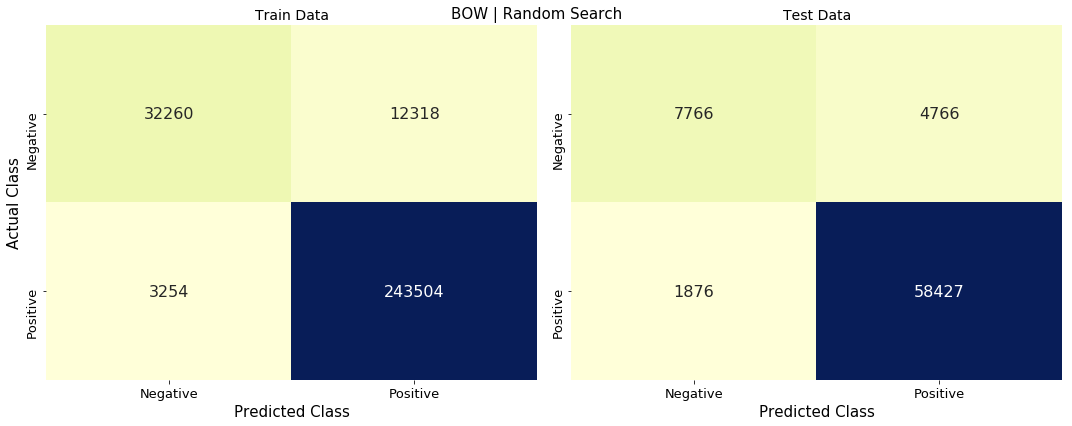

In [61]:
plot_confusion_matrix(cm_bow_train, cm_bow_test, "BOW | Random Search")

## Tfidf

In this section, we'll apply SGDClassifer on reviews represented in the Tfidf format. Load the transformed train and test sets.

In [62]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_tfidf_full_nparray.pkl', 'rb')
X_train_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_tfidf is : {}'.format(type(X_train_transformed_tfidf)))
print('The shape of X_train_transformed_tfidf is : {}'.format(X_train_transformed_tfidf.shape))

The datatype of X_train_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_tfidf is : (291336, 64221)


In [63]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_tfidf_full_nparray.pkl', 'rb')
X_test_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_tfidf is : {}'.format(type(X_test_transformed_tfidf)))
print('The shape of X_test_transformed_tfidf is : {}'.format(X_test_transformed_tfidf.shape))

The datatype of X_test_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_tfidf is : (72835, 64221)


**Standardize data**

In [64]:
scaler = StandardScaler(with_mean = False)
X_train_transformed_tfidf_std = scaler.fit_transform(X_train_transformed_tfidf)

In [65]:
X_test_transformed_tfidf_std = scaler.transform(X_test_transformed_tfidf)

**GridSearch | TFIDF **

In [66]:
clf_grid = GridSearch(X_train_transformed_tfidf_std)

Train the model

In [67]:
%%notify
%%time

clf_grid.fit(X_train_transformed_tfidf_std, y_train)

CPU times: user 1.97 s, sys: 134 ms, total: 2.11 s
Wall time: 8.68 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fed38145728>,
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=12,
       param_grid={'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Heatmap | Tfidf | Grid Search**

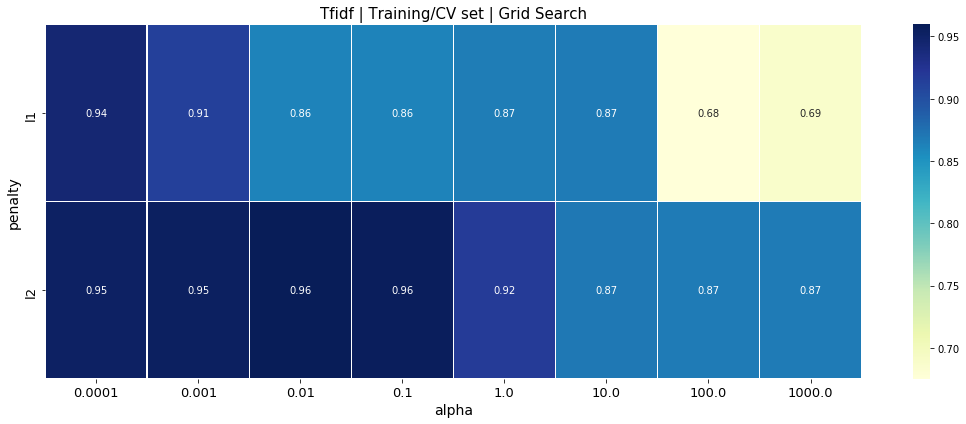

In [68]:
heatmap(penalty_alpha_score(clf_grid.cv_results_), vector_type='Tfidf', search_type='Grid Search')

**Ratios | Tfidf | Grid Search**

In [69]:
%%notify

cm_tfidf_train, cm_tfidf_test = give_me_ratios(X_train_transformed_tfidf_std, y_train, X_test_transformed_tfidf_std, y_test, 'TFIDF','Grid Search', table, clf_grid, clf_grid.best_params_['penalty'],clf_grid.best_params_['alpha'])

+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Vector Type  | Parameter Srch |  Data | Best penalty | Best alpha | Prec | Rec  | TNR  | FPR  | FNR  |  Acc   |
+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Bag of Words |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9461 |
| Bag of Words |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.61 | 0.39 | 0.03 | 0.9085 |
| Bag of Words | Random Search  | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9465 |
| Bag of Words | Random Search  |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.62 | 0.38 | 0.03 | 0.9088 |
|    TFIDF     |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.71 | 0.29 | 0.01 | 0.9444 |
|    TFIDF     |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.58

<IPython.core.display.Javascript object>

**Confusion Matrix | Tfidf | Grid Search**

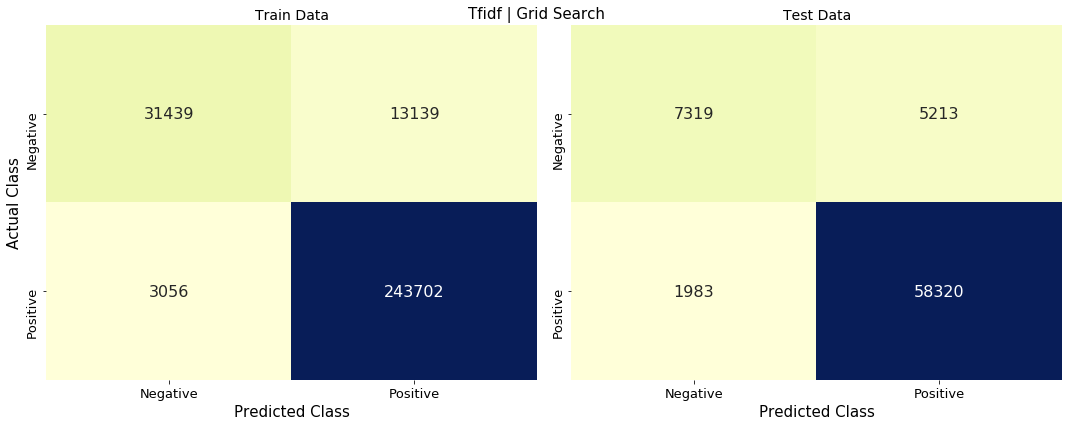

In [70]:
plot_confusion_matrix(cm_tfidf_train, cm_tfidf_test, "Tfidf | Grid Search")

**Random Search | TFIDF **

In [71]:
clf_random = RandomSearch(X_train_transformed_tfidf_std)

In [72]:
%%notify
%%time

clf_random.fit(X_train_transformed_tfidf_std, y_train)

CPU times: user 1.89 s, sys: 106 ms, total: 2 s
Wall time: 5.12 s


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fed71f068e0>,
          error_score='raise-deprecating',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=12,
          param_distributions={'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Heatmap | Tfidf | Random Search**

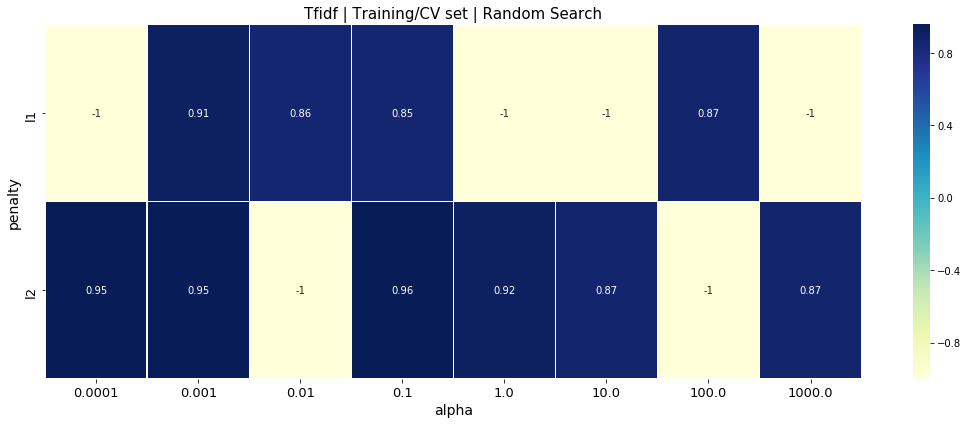

In [73]:
heatmap(penalty_alpha_score(clf_random.cv_results_), vector_type='Tfidf', search_type='Random Search')

**Ratios | Tfidf | Random Search**

In [74]:
cm_tfidf_train, cm_tfidf_test = give_me_ratios(X_train_transformed_tfidf_std, y_train, X_test_transformed_tfidf_std, y_test, 'TFIDF','Random Search', table, clf_random, clf_random.best_params_['penalty'],clf_random.best_params_['alpha'])

+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Vector Type  | Parameter Srch |  Data | Best penalty | Best alpha | Prec | Rec  | TNR  | FPR  | FNR  |  Acc   |
+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Bag of Words |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9461 |
| Bag of Words |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.61 | 0.39 | 0.03 | 0.9085 |
| Bag of Words | Random Search  | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9465 |
| Bag of Words | Random Search  |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.62 | 0.38 | 0.03 | 0.9088 |
|    TFIDF     |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.71 | 0.29 | 0.01 | 0.9444 |
|    TFIDF     |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.58

**Confusion Matrxi | Tfidf | Random Search**

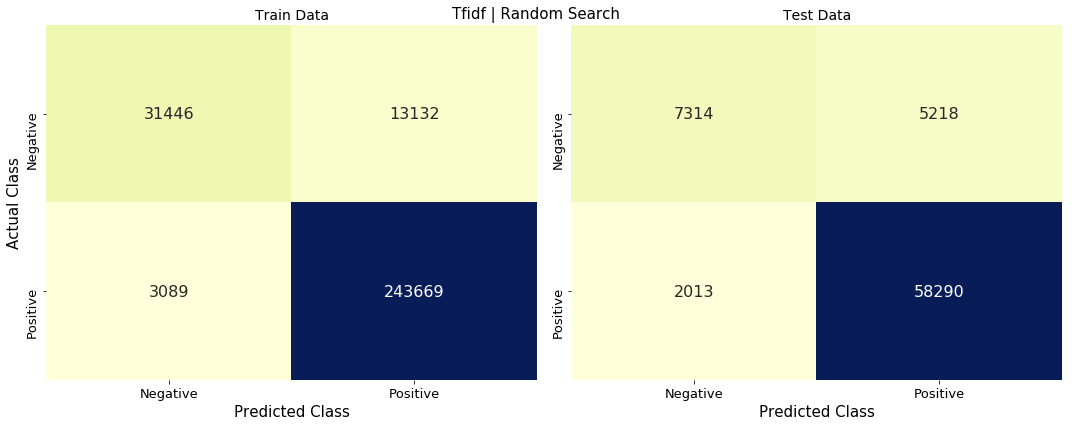

In [75]:
plot_confusion_matrix(cm_tfidf_train, cm_tfidf_test, "Tfidf | Random Search")

## Avg W2V

In this section, we'll apply SGDClassifier on data represented in the avg. W2V format.
load the train and test data stored on disk.

In [76]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [77]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_avgW2V is : {}'.format(type(X_test_transformed_avgW2V)))
print('The shape of X_test_transformed_avgW2V is : {}'.format(X_test_transformed_avgW2V.shape))

The datatype of X_test_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_test_transformed_avgW2V is : (72835, 50)


**Standardize the data**

In [78]:
scaler = StandardScaler(with_mean = True)
X_train_transformed_avgW2V_std = scaler.fit_transform(X_train_transformed_avgW2V)

In [79]:
X_test_transformed_avgW2V_std = scaler.transform(X_test_transformed_avgW2V)

**GridSearch | avg. W2V **



In [80]:
clf_grid = GridSearch(X_train_transformed_avgW2V_std)

In [81]:
%%notify
%%time

clf_grid.fit(X_train_transformed_avgW2V_std, y_train)

CPU times: user 1.79 s, sys: 90.9 ms, total: 1.88 s
Wall time: 8.21 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fed38145a98>,
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=12,
       param_grid={'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Heatmap | Avg. W2V | Grid Search**

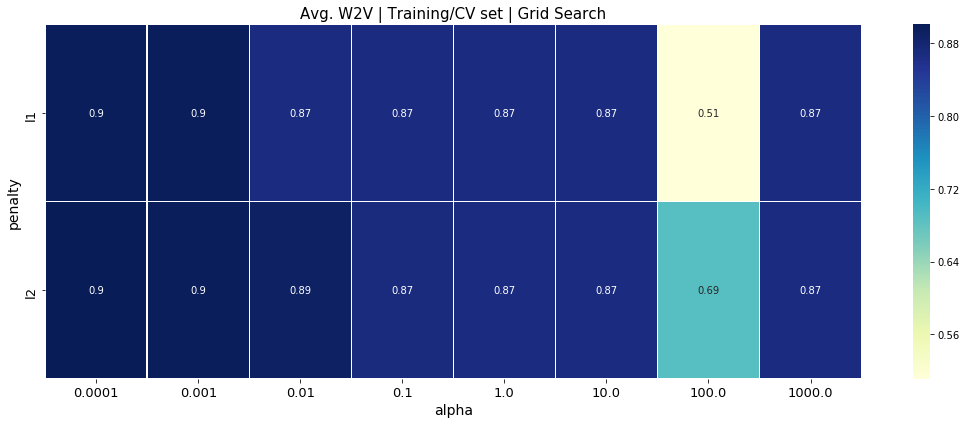

In [82]:
heatmap(penalty_alpha_score(clf_grid.cv_results_), vector_type='Avg. W2V', search_type='Grid Search')

**Ratios | Avg. W2V | Grid Search**

In [83]:
%%notify

cm_w2v_train, cm_w2v_test = give_me_ratios(X_train_transformed_avgW2V_std, y_train, X_test_transformed_avgW2V_std, y_test, 'Avg. W2V','Grid Search', table, clf_grid, clf_grid.best_params_['penalty'],clf_grid.best_params_['alpha'])

+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Vector Type  | Parameter Srch |  Data | Best penalty | Best alpha | Prec | Rec  | TNR  | FPR  | FNR  |  Acc   |
+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Bag of Words |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9461 |
| Bag of Words |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.61 | 0.39 | 0.03 | 0.9085 |
| Bag of Words | Random Search  | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9465 |
| Bag of Words | Random Search  |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.62 | 0.38 | 0.03 | 0.9088 |
|    TFIDF     |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.71 | 0.29 | 0.01 | 0.9444 |
|    TFIDF     |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.58

<IPython.core.display.Javascript object>

**Confusion Matrix | Avg. W2V | Grid Search**

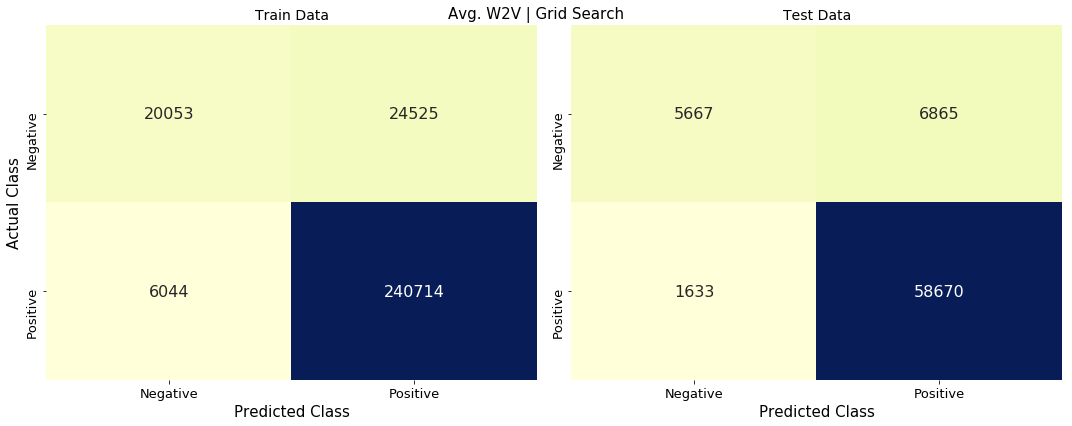

In [84]:
plot_confusion_matrix(cm_w2v_train, cm_w2v_test, "Avg. W2V | Grid Search")

**Random Search | avg. W2V **

In [85]:
clf_random = RandomSearch(X_train_transformed_avgW2V_std)

In [86]:
%%notify
%%time

clf_random.fit(X_train_transformed_avgW2V_std, y_train)

CPU times: user 1.74 s, sys: 89.9 ms, total: 1.83 s
Wall time: 4.79 s


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fed3ec3cfc0>,
          error_score='raise-deprecating',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=12,
          param_distributions={'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Heatmap | Avg. W2V | Random Search**

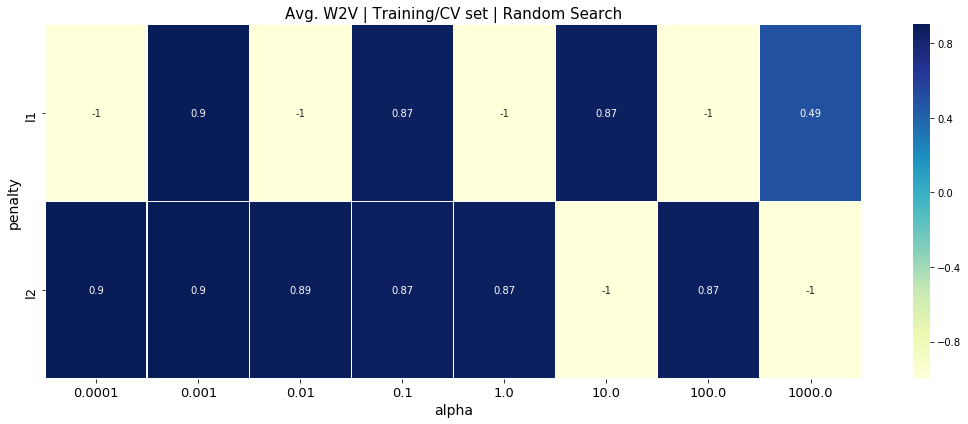

In [87]:
heatmap(penalty_alpha_score(clf_random.cv_results_), vector_type='Avg. W2V', search_type='Random Search')

**Ratios | Avg. W2V | Random Search**

In [88]:
%%notify

cm_w2v_train, cm_w2v_test = give_me_ratios(X_train_transformed_avgW2V_std, y_train, X_test_transformed_avgW2V_std, y_test, 'Avg. W2V','Random Search', table, clf_random, clf_random.best_params_['penalty'],clf_random.best_params_['alpha'])

+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Vector Type  | Parameter Srch |  Data | Best penalty | Best alpha | Prec | Rec  | TNR  | FPR  | FNR  |  Acc   |
+--------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
| Bag of Words |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9461 |
| Bag of Words |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.61 | 0.39 | 0.03 | 0.9085 |
| Bag of Words | Random Search  | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9465 |
| Bag of Words | Random Search  |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.62 | 0.38 | 0.03 | 0.9088 |
|    TFIDF     |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.71 | 0.29 | 0.01 | 0.9444 |
|    TFIDF     |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.58

<IPython.core.display.Javascript object>

**Confusion Matrix | Avg. W2V | Random Search**

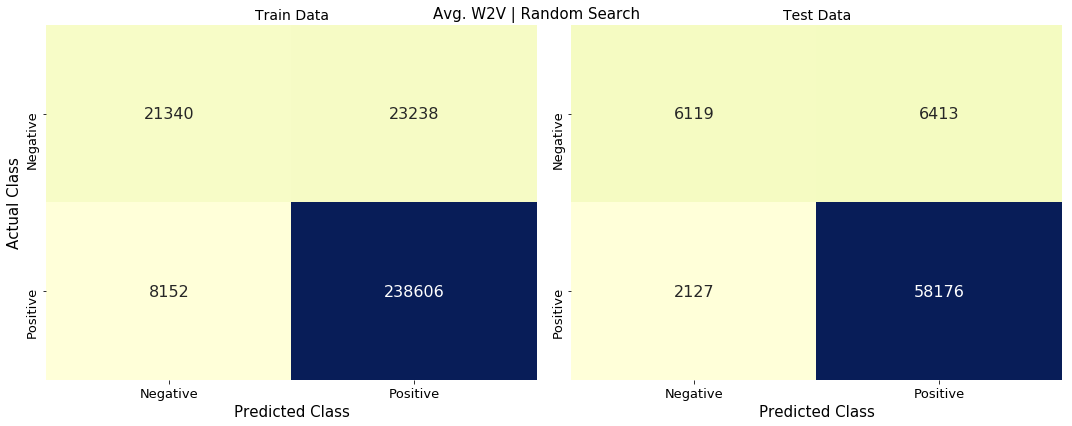

In [89]:
plot_confusion_matrix(cm_w2v_train, cm_w2v_test, "Avg. W2V | Random Search")

## Tfidf weighted W2V

In this last section, we apply SGDClassifier on vectors represented in the form of Tfidf weighted W2V.

In [90]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_TfidfW2V is : {}'.format(type(X_train_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_train_transformed_TfidfW2V.shape))

The datatype of X_train_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (291336, 50)


In [91]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_TfidfW2V is : {}'.format(type(X_test_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_test_transformed_TfidfW2V.shape))

The datatype of X_test_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (72835, 50)


**Standardize data**

In [92]:
scaler = StandardScaler(with_mean = True)
X_train_transformed_TfidfW2V_std = scaler.fit_transform(X_train_transformed_TfidfW2V)

In [93]:
X_test_transformed_TfidfW2V_std = scaler.transform(X_test_transformed_TfidfW2V)

**GridSearch | Tfidf Weighted W2V**

In [94]:
clf_grid = GridSearch(X_train_transformed_TfidfW2V_std)

In [95]:
%%notify
%%time

clf_grid.fit(X_train_transformed_TfidfW2V_std, y_train)

CPU times: user 1.78 s, sys: 87.7 ms, total: 1.87 s
Wall time: 7.52 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fed380494c0>,
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=12,
       param_grid={'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Heatmap | Tfidf wt. W2V | Grid Search**

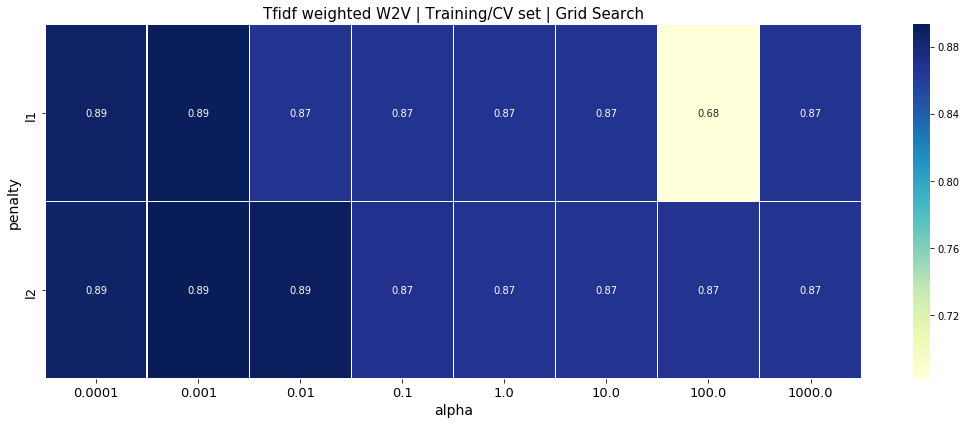

In [96]:
heatmap(penalty_alpha_score(clf_grid.cv_results_), vector_type='Tfidf weighted W2V', search_type='Grid Search')

**Ratios | Tfidf wt. W2V | Grid Search**

In [97]:
cm_tfidfw2v_train, cm_tfidfw2v_test = give_me_ratios(X_train_transformed_TfidfW2V_std, y_train, X_test_transformed_TfidfW2V_std, y_test, 'Tfidf wt. W2V','Grid Search', table, clf_grid, clf_grid.best_params_['penalty'],clf_grid.best_params_['alpha'])

+---------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
|  Vector Type  | Parameter Srch |  Data | Best penalty | Best alpha | Prec | Rec  | TNR  | FPR  | FNR  |  Acc   |
+---------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
|  Bag of Words |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9461 |
|  Bag of Words |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.61 | 0.39 | 0.03 | 0.9085 |
|  Bag of Words | Random Search  | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9465 |
|  Bag of Words | Random Search  |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.62 | 0.38 | 0.03 | 0.9088 |
|     TFIDF     |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.71 | 0.29 | 0.01 | 0.9444 |
|     TFIDF     |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.

**Confusion Matrix | Tfidf wt. W2V | Grid Search**

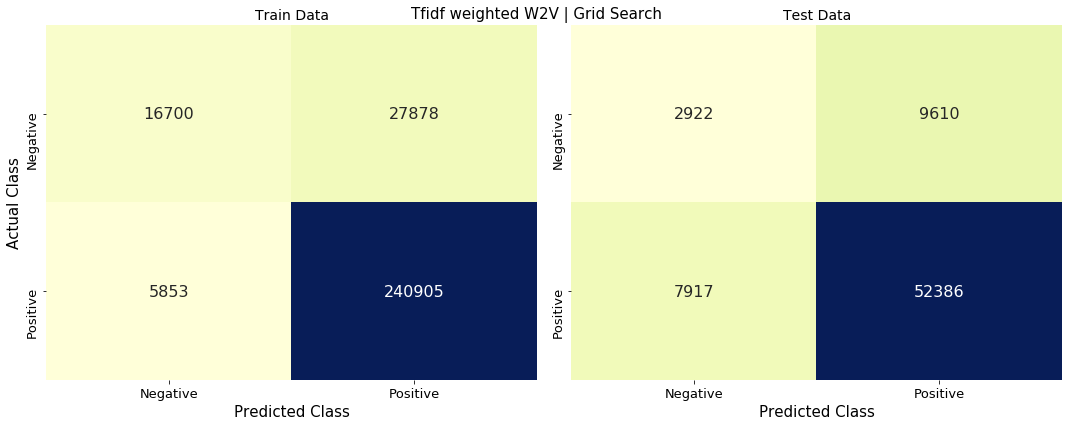

In [98]:
plot_confusion_matrix(cm_tfidfw2v_train, cm_tfidfw2v_test, "Tfidf weighted W2V | Grid Search")

**Random Search | Tfidf Weighted W2V**

In [99]:
clf_random = GridSearch(X_train_transformed_TfidfW2V_std)

In [100]:
%%notify
%%time

clf_random.fit(X_train_transformed_TfidfW2V_std, y_train)

CPU times: user 1.86 s, sys: 103 ms, total: 1.97 s
Wall time: 7.57 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fed38049fc0>,
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=12,
       param_grid={'penalty': ['l1', 'l2'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>

**Heatmap | Tfidf wt. W2V | Random Search**

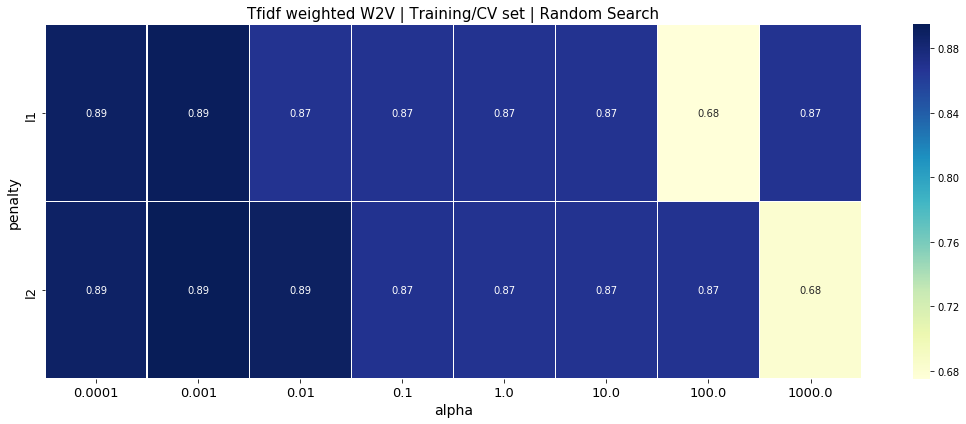

In [101]:
heatmap(penalty_alpha_score(clf_random.cv_results_), vector_type='Tfidf weighted W2V', search_type='Random Search')

**Ratios | Tfidf wt. W2V | Random Search**

In [102]:
cm_tfidfw2v_train, cm_tfidfw2v_test =  give_me_ratios(X_train_transformed_TfidfW2V_std, y_train, X_test_transformed_TfidfW2V_std, y_test, 'Tfidf wt. W2V','Random Search', table, clf_random, clf_random.best_params_['penalty'],clf_random.best_params_['alpha'])

+---------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
|  Vector Type  | Parameter Srch |  Data | Best penalty | Best alpha | Prec | Rec  | TNR  | FPR  | FNR  |  Acc   |
+---------------+----------------+-------+--------------+------------+------+------+------+------+------+--------+
|  Bag of Words |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9461 |
|  Bag of Words |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.61 | 0.39 | 0.03 | 0.9085 |
|  Bag of Words | Random Search  | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.72 | 0.28 | 0.01 | 0.9465 |
|  Bag of Words | Random Search  |  Test |      l2      |    0.1     | 0.92 | 0.97 | 0.62 | 0.38 | 0.03 | 0.9088 |
|     TFIDF     |  Grid Search   | Train |      l2      |    0.1     | 0.95 | 0.99 | 0.71 | 0.29 | 0.01 | 0.9444 |
|     TFIDF     |  Grid Search   |  Test |      l2      |    0.1     | 0.92 | 0.

**Confusion Matrix | Tfidf wt. W2V | Random Search**

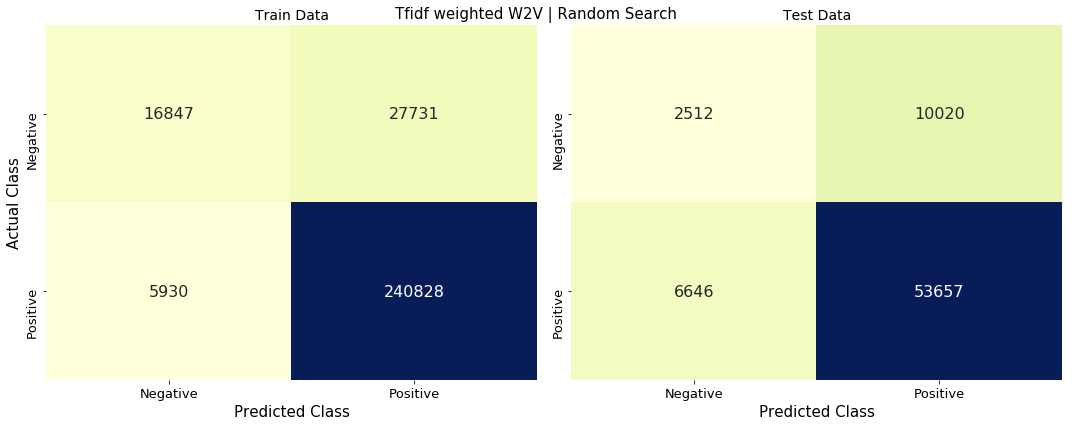

In [103]:
plot_confusion_matrix(cm_tfidfw2v_train, cm_tfidfw2v_test, "Tfidf weighted W2V | Random Search")

### Conclusion:

* Applied SGDClassifer on amazon food reviews for various vector representations.

* Found the best penalty and alpha using GridSearch and RandomizedSearch. 
* Plotted the confusion matrix for train and test data and also calculated several important ratios based on it such as Precision, Recall, FNR, etc.

* Compared to SVM with 'rbf' kernel, the SGDClassifer was not found to have any significant advantage in terms of precision, recall or accuracy. But Being a linear classifier, SGDClassifier is much faster compared to SVM with 'rbf'.